# Week 3: Temporal Difference Methods

#### Authored By: Mithun Vanniasinghe

This notebook exerercise will cover 2 temporal difference based methods in learning optimal polcies for the cliff walking enviroment, SARSA and Q-Learning!

In [71]:
from IPython.display import Image
Image(url="https://gymnasium.farama.org/_images/cliff_walking.gif")


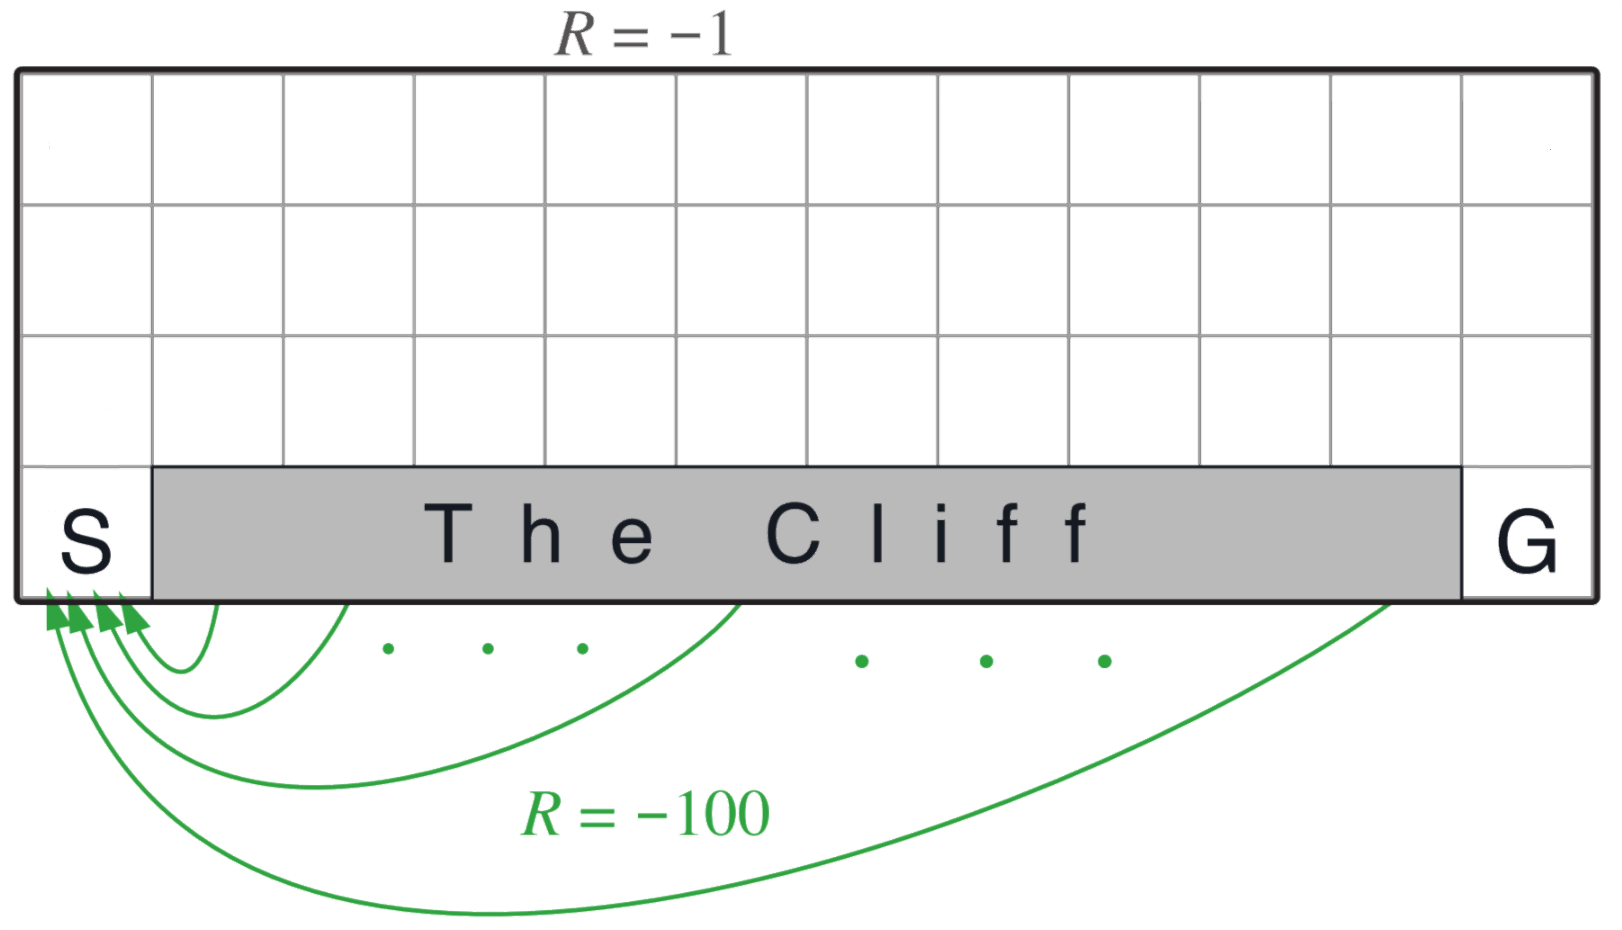

In [72]:
!pip install gymnasium
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import gymnasium as gym

## Create the Enviroment

In this week, we will use the cliff walking enviroment from Gymnasium (formerly Gym), an open-source toolkit for developing and evaluating reinforcement learning (RL) algorithms. It is a community-driven project and is part of the OpenAI Gym family. Gymnasium serves as a platform for testing and benchmarking RL agents in a variety of environments.

There are 48 total possible states.

The game starts with the player at location `[3, 0]` of the 4x12 grid world with the goal located at `[3, 11]`. If the player reaches the goal the episode ends.

A cliff runs along `[3, 1..10]`. If the player moves to a cliff location it returns to the start location.

The player makes moves until they reach the goal.

### Action Space
The action shape is `(1,)` in the range `{0, 3}` indicating which direction to move the player.

0: Move up

1: Move right

2: Move down

3: Move left

### State Space
There are 3 x 12 + 1 possible states. The player cannot be at the cliff, nor at the goal as the latter results in the end of the episode. What remains are all the positions of the first 3 rows plus the bottom-left cell.

The observation is a value representing the player’s current position as current_row * ncols + current_col (where both the row and col start at 0).

For example, the starting position can be calculated as follows: 3 * 12 + 0 = 36.

The observation is returned as an int().

### Starting State
The episode starts with the player in state `[36]` (location `[3, 0])`.

### Reward
Each time step incurs -1 reward, unless the player stepped into the cliff, which incurs -100 reward.

### Note:
In this enviroment, all transition are deterministic. Meaning, if you move in any allowed direction, so will determinicataclly move to the next appropriate state (there is no uncertainty with the transition)

In [73]:
env = gym.make('CliffWalking-v0', render_mode="ansi")
observation, info = env.reset()
print(observation, info) # print out starting state, note how we start in state 36 (bottom left) and how the transition probabilty is always 1

36 {'prob': 1}


# SARSA Agent

Here we implemet the SARSA agent.

Recal SARSA stands for state, action, reward, state, action. Using a one step lookhead, we update the action value function with the following update equation:

$$
Q(S,A) ← Q(S,A) + α [R + γ Q(S', A') - Q(S,A)]
$$

Try implementing this udpate below

In [74]:
class SarsaAgent:
  def __init__(self, agent_info):
    '''
    Setup for the agent at the begining of the experiment
    agent_init_info (dict), the parameters used to initialize the agent. The dictionary contains:
        {
            num_states (int): The number of states,
            num_actions (int): The number of actions,
            epsilon (float): The epsilon parameter for exploration,
            step_size (float): The step-size,
            discount (float): The discount factor,
        }
    '''
    self.num_actions = agent_info["num_actions"]
    self.num_states = agent_info["num_states"]
    self.epsilon = agent_info["epsilon"]
    self.step_size = agent_info["step_size"]
    self.discount = agent_info["discount"]
     # fix the random seed for when we use epsilon greedy action selection for reproducibilty
    self.rand_generator = np.random.RandomState(agent_info["seed"])

    self.action_vals = np.zeros((self.num_states, self.num_actions)) # random init the q function (just init to zeros here but can be random)
    # in cliff walking env, terminal state is indexed by 47
    # ensure terminal state has a value of 0 (the world ends so no more actions possible => 0 value)
    self.action_vals[47, :] = np.zeros(self.num_actions)

    # these will be requried to make the TD updates
    self.prev_state = None
    self.prev_action = None

  def _epsilson_greedy(self, state):
    '''
    Based on the current action value function, does an epsilon greedu action selection

    Args:
      state: the current state the agent is in
    Returns:
      action (int) the agent's action choice
    '''
    if self.rand_generator.rand() < self.epsilon:
      action = self.rand_generator.randint(self.num_actions)
    else:
      # break ties randomly when doing argmax
      max_value = np.max(self.action_vals[state, :])
      max_indices = np.where(self.action_vals[state, :] == max_value)[0]
      action = self.rand_generator.choice(max_indices)

    return action


  def agent_start(self, observation):
    '''Called when the episode first starts
    Args:
      observation (int): the state observation from the starting of the enviroment

    Returns:
      action(int) the first action the agent takes
    '''
    action = self._epsilson_greedy(state=observation)
    # to later perform the sarsa/q-learning updates we need to keep track of the prev action and state
    self.prev_state = observation
    self.prev_action = action
    return action

  def agent_step(self, reward, observation):
    '''
    Agent takes a step in the enviroment and updates its action value estimates

    Args:
      reward (float): the reward from the enviroment for the previous transition
      observation (int): the state the agent is in from the previous transition
    Returns:
      action (int): the action taken by the agent

    '''
    # First perform the action selection for the current state
    action = self._epsilson_greedy(state=observation)

    # Perform SARSA Update
    td_error = reward + self.discount * self.action_vals[observation, action] - self.action_vals[self.prev_state,self.prev_action]
    self.action_vals[self.prev_state, self.prev_action] += self.step_size * td_error

    self.prev_state = observation
    self.prev_action = action

    return action

  def agent_end(self, reward):
    '''
    Runs when the agent reaches the terminal state
    Args:
      reward(float): reward for transitioning into the terminal state
    '''

    # Note: no more action selection since in a terminal state
    # Just update the action values with the SARSA update rule
    # Recall, terminal states have zero value

    td_error = reward - self.action_vals[self.prev_state,self.prev_action]
    self.action_vals[self.prev_state, self.prev_action] += self.step_size * td_error


# Training Simulation

Now that you have coded the SARSA agent, let's run the training loop. The training loop has been written for you. It runs an experiment of `num_episodes` for a repeated `num_runs` times. This is down so that we can analayze the average reward we get over all experiments for a less noisy analysis.

The training function also keep tracks of the number of times each state is visited. The importance of this will be seen when we want to analyze SARSA vs Q-Learning

In [75]:
agent_info = {"num_actions": 4, "num_states": 48, "epsilon": 0.1, "step_size": 0.5, "discount": 1.0, "seed": 0}

# helper function for running the training loop
def training_loop(agent_class, agent_info=agent_info, num_runs=100, num_episodes=200):
  num_runs = 100 # The number of runs
  num_episodes = 200 # The number of episodes in each run
  env = gym.make('CliffWalking-v0')

  all_rewards= []
  total_state_visits = []
  for run in tqdm(range(num_runs)):
    agent_info["seed"] = run
    reward_sums = []
    agent = agent_class(agent_info=agent_info)
    max_steps = 1000
    state_visits = np.zeros(48)

    for episode in range(num_episodes):
      total_reward = 0
      num_steps = 0
      state, info = env.reset()
      action = agent.agent_start(state)
      state_visits[state] += 1
      is_terminal = False

      while not is_terminal and num_steps < max_steps: # keep going until time out or reach terminal state
        state, reward, is_terminal, _, _ = env.step(action)
        num_steps += 1
        total_reward += reward

        if is_terminal:
          agent.agent_end(reward)
        else:
          action = agent.agent_step(reward, state)

        state_visits[state] += 1

      reward_sums.append(total_reward) # sum of rewards for this episode
    all_rewards.append(reward_sums) # to average over the episodes
    total_state_visits.append(state_visits)

  return all_rewards, total_state_visits


### Plot to see performance

Here we plot the average reward over all runs (for less noisy analysis). You should notice the cumulative reward increasing over time!

100%|██████████| 100/100 [00:42<00:00,  2.36it/s]


Text(0, 0.5, 'Sum of\n rewards\n during\n episode')

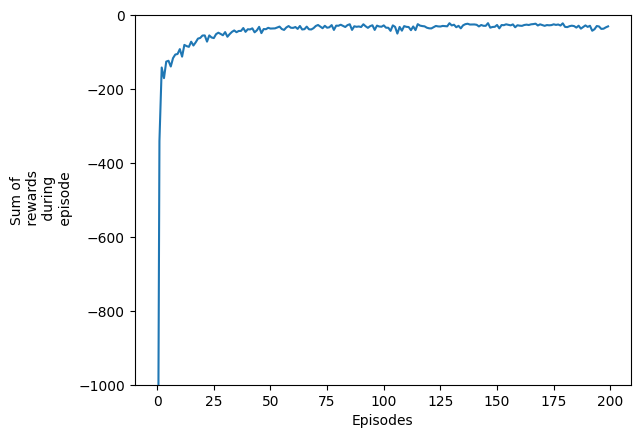

In [76]:
sarsa_rewards, sarsa_state_visits = training_loop(agent_class=SarsaAgent)
plt.plot(np.mean(sarsa_rewards, axis=0))
plt.ylim(-1000,0)
plt.xlabel("Episodes")
plt.ylabel("Sum of\n rewards\n during\n episode")

# Q-Learning Agent

Now try implementing the Q learning agnet. Notice how we can reuse all the methods from the SARSA agent. The only method that needs to be re-writtten is the `agent_step` method since the Q learning agent follows a different update rule given by the following:

$$
Q(S,A) ← Q(S,A) + α [R + γ \max_{a} Q(S',a) - Q(S,A)]
$$

Try implementing this udpate below

In [77]:
class QAgent(SarsaAgent):
  def agent_step(self, reward, observation):
    '''
    Agent takes a step in the enviroment and updates its action value estimates

    Args:
      reward (float): the reward from the enviroment for the previous transition
      observation (int): the state the agent is in from the previous transition
    Returns:
      action (int): the action taken by the agent

    '''
    # First perform the action selection for the current state
    action = self._epsilson_greedy(state=observation)

    # Perform SARSA Update
    td_error = reward + self.discount * np.max(self.action_vals[observation, :]) - self.action_vals[self.prev_state,self.prev_action]
    self.action_vals[self.prev_state, self.prev_action] += self.step_size * td_error

    self.prev_state = observation
    self.prev_action = action

    return action

100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Text(0, 0.5, 'Sum of\n rewards\n during\n episode')

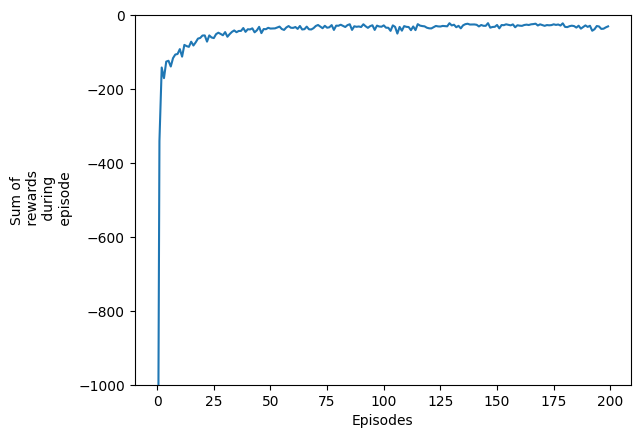

In [78]:
# Run the experiment with the Q-Learning Agent + Plot average reward over al runs
q_rewards, q_state_visits = training_loop(agent_class=QAgent)
plt.plot(np.mean(sarsa_rewards, axis=0))
plt.ylim(-1000,0)
plt.xlabel("Episodes")
plt.ylabel("Sum of\n rewards\n during\n episode")

## Compare SARSA and Q-Learning

Compare which reinforcement learning algorithm performs better. SARSA is seen to perform better, why is this.

Recall, SARSA is an on-policy learning algorithm, which means it updates its action value functions based upon the policy it is currently following. If the agent experiences a bad state (like falling off the cliff), this agent updates it action value functions based on this policy and thus is less likely to visit this bad state again. This "knowledge" becomes "encoded" into the action value function.

\\

On the other hand, Q-Learng is an off-policy learning algorithm. This means it doesn't learn the policy it is currently following. This can be seen with the max operation in the update equation. The update is done "as if" the agent is following the optimal policy". This allows Q-Learning to effectivley learn optimal policies but results in a drawback since the updates to the action value functions are not made entirely on past experience. This can lead the agent to more "bad" states when exploration happens

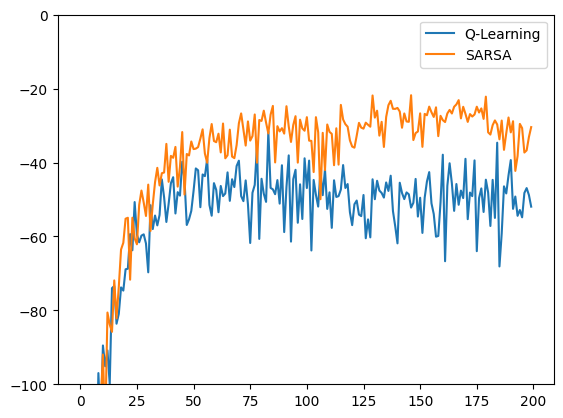

In [79]:
plt.plot(np.mean(q_rewards, axis=0), label="Q-Learning")
plt.plot(np.mean(sarsa_rewards, axis=0), label="SARSA")
plt.ylim(-100,0)
plt.legend()
plt.show()

## Understanding SARSA vs Q-Learning

Let's look at the average state visitations for the SARSA vs Q-Learning Agents across the runs to see their behaviour.

Notice how the SARSA agent learns the more safer (but less optimal) path to the end goal wheras the Q Learning Agent learns the more optimal (but more dangerous path to the goal).

 \\

This is exactly why the Q Learning agent underperforms in the online setting. It uses learns an optimal policy but due to not acting with "encoded knowledge" of its past consequences, it can be prone to falling off the cliff when the exploration kicks in. Since explroation can lead to any random action, if the agent is in a state close to the cliff (one that follows the optimal path) the agent can possibly fall off the cliff if it explores with some probability.

\\

The SARSA agent learns the safer path since it is aware of its previous consequences from being in certain "bad" states (such as those close to the cliff) because it's update takes into account the history of its trajectory. This allows the SARSA to avoid being in bad states when exloration kicks in.

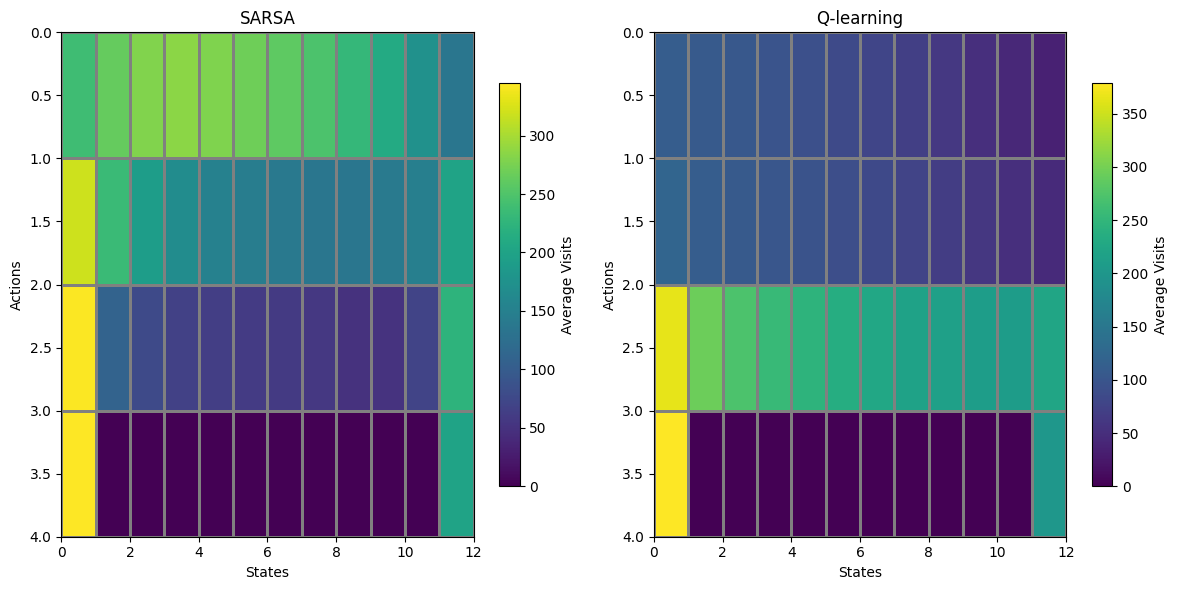

In [80]:
# compute average visitiation for each state over all runs for each agent
sarsa_average_state_visits = np.array(sarsa_state_visits).mean(axis=0)
q_average_state_visits = np.array(q_state_visits).mean(axis=0)
sarsa_grid = sarsa_average_state_visits.reshape((4,12)) # reshape into grid size
q_grid = q_average_state_visits.reshape((4,12))


fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # Two plots side by side

# Plot SARSA grid
sarsa_plot = axs[0].pcolormesh(sarsa_grid, edgecolors='gray', linewidth=2)
axs[0].set_title('SARSA')
axs[0].set_xlabel('States')
axs[0].set_ylabel('Actions')
axs[0].set_ylim(4, 0)  # Reverse y-axis to match grid layout

# Plot Q-learning grid
q_plot = axs[1].pcolormesh(q_grid, edgecolors='gray', linewidth=2)
axs[1].set_title('Q-learning')
axs[1].set_xlabel('States')
axs[1].set_ylabel('Actions')
axs[1].set_ylim(4, 0)  # Reverse y-axis to match grid layout

# Create colorbars for both plots, sharing the same color map
fig.colorbar(sarsa_plot, ax=axs[0], shrink=0.8, label="Average Visits")
fig.colorbar(q_plot, ax=axs[1], shrink=0.8, label="Average Visits")


# Show the plot
plt.tight_layout()
plt.show()

## Takeaways

It is important when to know to use SARSA or Q-Learning. When we just care about learning optimal polices, usually Q-Learning is the way to go. However, if we care about online performance (this may be important in safety critical enviroments like this cliff walking example) SARSA may be better!